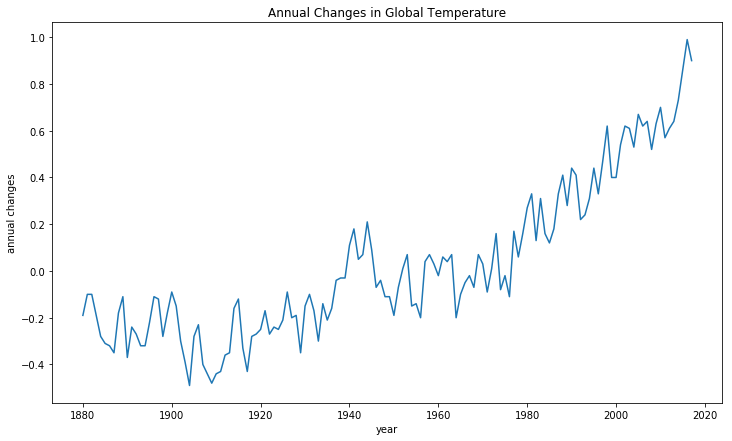

In [3]:
import numpy as np
import matplotlib.pylab as plt
import csv

data = open('data/Global_Temperature.csv','r')
dataline = csv.reader(data)
year_list = []
data_origin_list = []
for line in dataline:
    data_origin_list.append(float(line[1]))
    year_list.append(int(line[0][-4:]))
    
year = np.array(year_list)
data_origin = np.array(data_origin_list,dtype='float64')

fig_1 = plt.figure()
fig_1.set_size_inches(12,7)

plt.xlabel('year')
plt.ylabel('annual changes')
plt.title('Annual Changes in Global Temperature')
plt.plot(year,data_origin)
# plt.savefig('output/original_data.png')
plt.show()

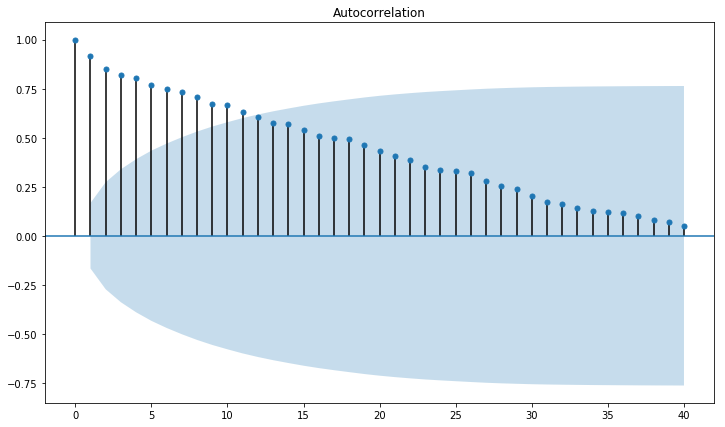

In [4]:
%matplotlib inline
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot original acf
plt.rcParams['figure.figsize'] = (12, 7)

plot_acf(data_origin,lags=40)
# plt.savefig('output/ACF_original_data.png')
plt.show()

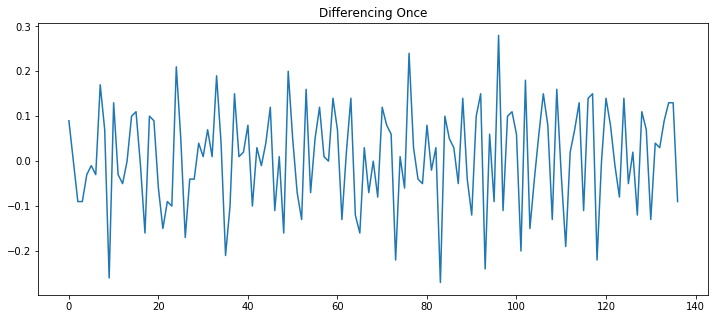

In [5]:
# differencing once and plot the data
data_diff1 = np.diff(data_origin)
fig_2 = plt.figure()
fig_2.set_size_inches(12,5)
plt.plot(np.arange(np.shape(data_diff1)[0]),data_diff1)
plt.title('Differencing Once')
# plt.savefig('output/Differencing_Once.png')
plt.show()

/Users/yuanyuan/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


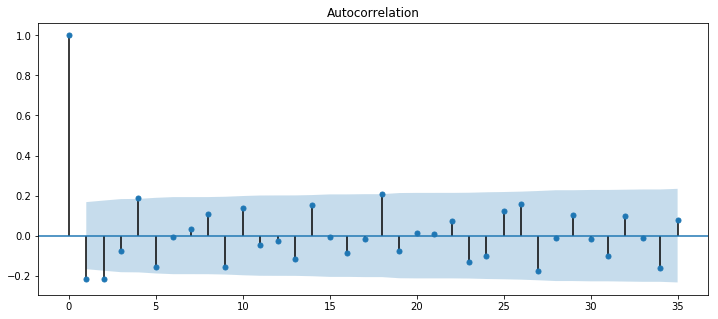

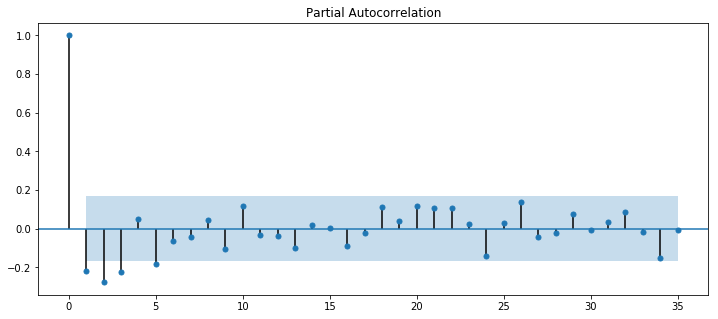

In [6]:
# plot acf and pacf of differencing once
plt.rcParams['figure.figsize'] = (12, 5)
plot_acf(data_diff1,lags=35).show()
# plt.savefig('output/Sample_acf_1.png')
plot_pacf(data_diff1,lags=35).show()
# plt.savefig('output/Sample_pacf_1.png')

Suitable lam is:  -0.37
Max llf is:  166.06


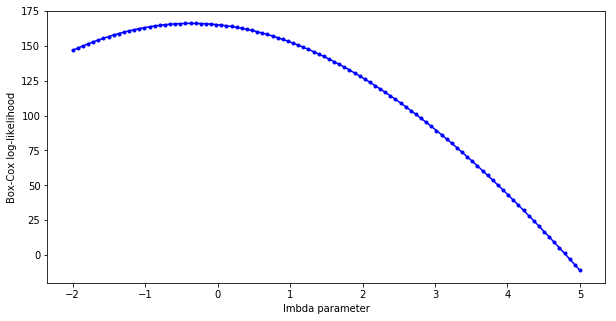

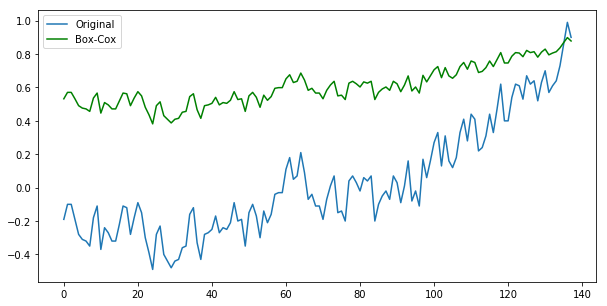

In [8]:
# box-cox transformation 
from scipy import stats,special

lam_range = np.linspace(-2,5,100)  # default nums=50
llf = np.zeros(lam_range.shape, dtype=float)


c=1
data_trans_1 = data_origin + c
# lambda estimate:
for i,lam in enumerate(lam_range):
    llf[i] = stats.boxcox_llf(lam, data_trans_1)
    
# find the max lgo-likelihood(llf) index and decide the lambda
lam_best = lam_range[llf.argmax()]
print('Suitable lam is: ',round(lam_best,2))
print('Max llf is: ', round(llf.max(),2))

plt.rcParams['figure.figsize'] = (10, 5)
plt.figure()
plt.plot(lam_range,llf,'b.-')

plt.xlabel('lmbda parameter')
plt.ylabel('Box-Cox log-likelihood')
# plt.savefig('Box_cox log_likelihood function')

plt.show()

# boxcox convert:
# inverse boxcox convert:
data_boxcox = special.boxcox1p(data_trans_1, lam_best)
data_invboxcox = special.inv_boxcox1p(data_boxcox, lam_best) - c 

plt.plot(data_origin, label='Original')
plt.plot(data_boxcox, color='green',label='Box-Cox')

plt.legend()
# plt.savefig('BoxCoxTran.png')
plt.show()

In [6]:
from statsmodels.tsa.arima_model import ARIMA
# print('(p,q)  aic')
# smallest_aic = 100
# smallest_combination= (0,0)
# for p in range(9):
#     for q in range(7):
#         model = ARIMA(data_boxcox, order=(p, 1, q))  
#         try:
#             result = model.fit(disp=-1) 
#             aic = result.aic
#             if aic< smallest_aic:
#                 smallest_aic = aic
#                 smallest_combination= (p,q)
#             print('(',p,q,')  ', aic)
#         except:    
#             pass
        
# print('finished')
# print('smallest aic is:',smallest_aic )
# print('where the combination of p and q is:',smallest_combination)

In [15]:
from statsmodels.tsa.arima_model import ARIMA
smallest_combination= (1,3)

model = ARIMA(data_boxcox, order=(smallest_combination[0], 1, smallest_combination[1]))
result = model.fit(disp=-1)
print(result.summary().tables[1])
print(result.summary().tables[2])
# print(result.fittedvalues())
# print(result.params)
# print(result.bse)

/Users/yuanyuan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/yuanyuan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      2.132      0.035       0.000       0.005
ar.L1.D.y     -0.9275      0.067    -13.860      0.000      -1.059      -0.796
ma.L1.D.y      0.6144      0.100      6.168      0.000       0.419       0.810
ma.L2.D.y     -0.5954      0.087     -6.841      0.000      -0.766      -0.425
ma.L3.D.y     -0.3731      0.079     -4.752      0.000      -0.527      -0.219
                                    Roots                                    
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0781           +0.0000j            1.0781            0.5000
MA.1            1.2903           +0.0000j            1.2903            0.0000
MA.2           -1.3706           +0.0000j            1.37

Text(0.5, 1.0, 'RSS: 0.2152')

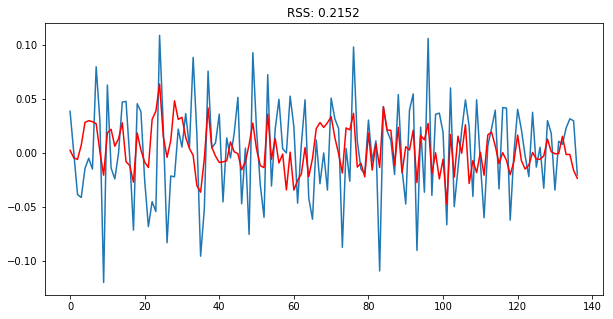

In [25]:
data_diff1_boxcox = np.diff(data_boxcox)
plt.plot(data_diff1_boxcox)
plt.plot(result.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((result.fittedvalues-data_diff1_boxcox)**2))





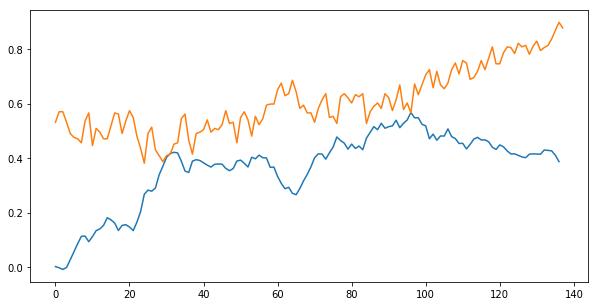

In [46]:
recover_test_1 = np.cumsum(result.fittedvalues)
plt.plot(recover_test_1)
plt.plot(data_boxcox)
plt.show()

/Users/yuanyuan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


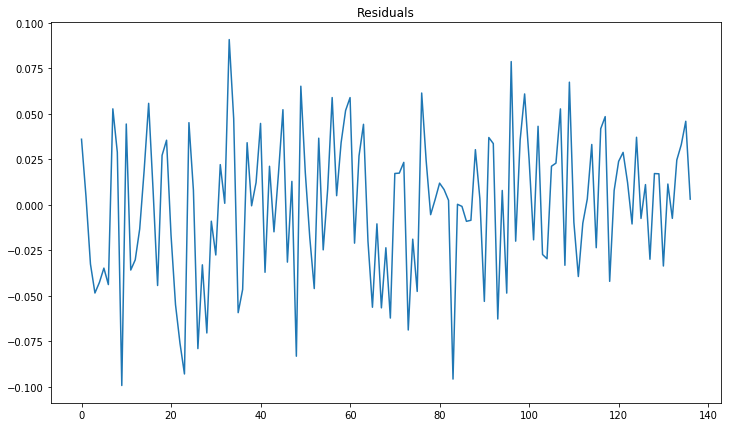

In [10]:
# show resid
resid = result.resid#残差
plt.rcParams['figure.figsize'] = (12, 7)
plt.plot(resid)
plt.title('Residuals')
plt.savefig('output/Residuals.png')
plt.show()

2.00281969200118


/Users/yuanyuan/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


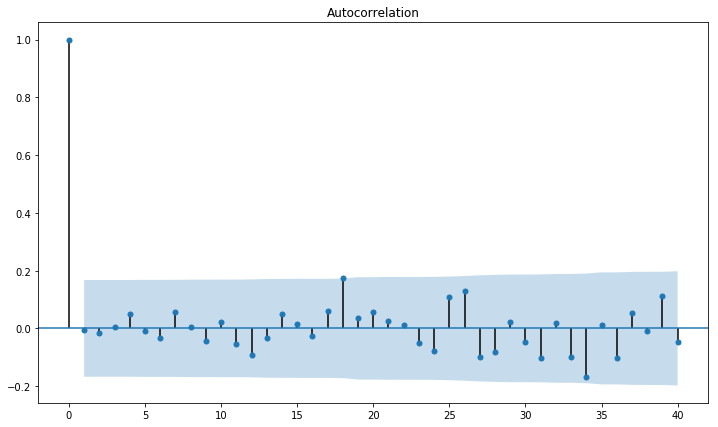

In [14]:
# Diagnostic check
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot


print(sm.stats.durbin_watson(resid))


# whiteness check
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=40, ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
plt.savefig('output/RACF.png')
fig.show()

/Users/yuanyuan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


NormaltestResult(statistic=3.4546367013821575, pvalue=0.17776046260317946)


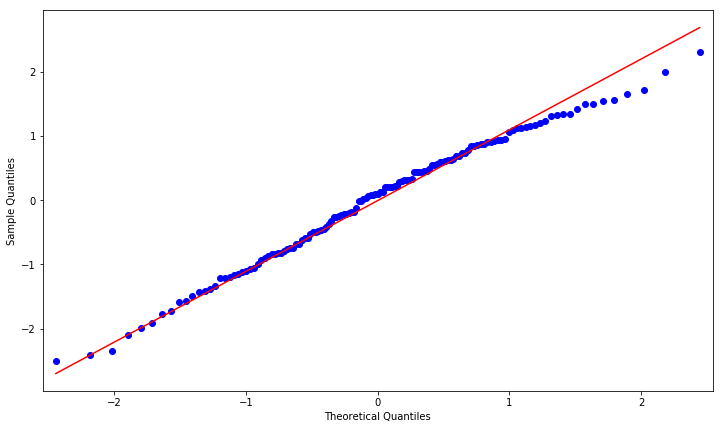

In [16]:
# normtest
from scipy.stats import normaltest

fig = qqplot(resid, line='q', fit=True)
fig.savefig('output/QQplot.png')
print(normaltest(resid, axis=None))

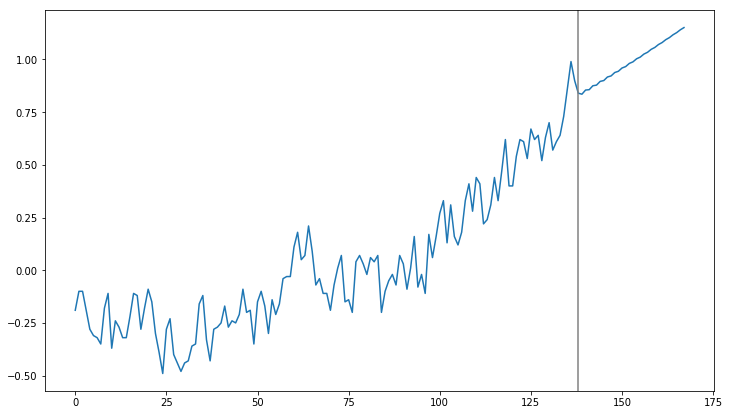

[0.03956266 0.0479968  0.05031855 0.05162476 0.05371809 0.05499441
 0.05690645 0.05815497 0.05991991 0.06114197 0.06278542 0.06398196
 0.06552355 0.06669538 0.06815048 0.06929829 0.07067914 0.07180361
 0.07312008 0.07422189 0.07548204 0.07656188 0.07777236 0.07883092
 0.07999729 0.08103527 0.08216219 0.08318029 0.0842717  0.08527063]


In [19]:
# forecast
forecast = result.forecast(30)
forecast_invboxcox = special.inv_boxcox1p(forecast[0], lam_best) - c 

temp_list = data_origin_list.copy()
for item in forecast_invboxcox:
    temp_list.append(float(item))
    
forecast_add_origin = np.array(temp_list,dtype='float64')   
plt.plot(forecast_add_origin)
# plt.plot(forecast[0],color='green')

plt.axvline(138,color='grey')
# plt.savefig('output/Forecast.png')
plt.show()
print(forecast[1])

/Users/yuanyuan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


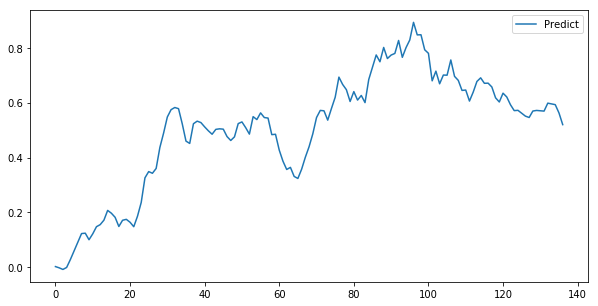

In [43]:
# predict
from scipy.ndimage.interpolation import shift
predict = result.predict()

# diff_shift = shift(data_diff1, 1, cval=np.NaN)
# print(len(diff_shift))
# diff_recover_1 = predict+ diff_shift

recover = np.cumsum(predict)

recover2 = np.cumsum(data_diff1)
predict_invboxcox = special.inv_boxcox1p(recover, lam_best)

plt.plot(predict_invboxcox, label='Predict')
# plt.plot(recover, color='green', label='recover')
# plt.plot(recover2, color='red', label='recover2')
# plt.plot(data_origin, color='black',label='origin')

# plt.plot(recover2)
# plt.plot(data_origin, color='red')
# plt.plot(data_diff1, color='green', label='Original')
# plt.title('RMSE: %.4f'% np.sqrt(sum((recover-recover2)**2)/len(predict)))
plt.legend(loc='best')
plt.savefig('Predict.png')
plt.show()

/Users/yuanyuan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/yuanyuan/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


[-0.93071133  0.65202247 -0.51179206 -0.31405505]


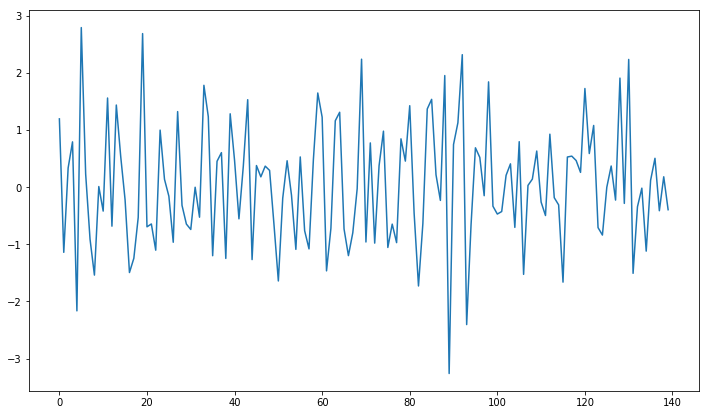

In [36]:
arparams = np.array([-0.9275])
maparams = np.array([0.6144, -0.5954,-0.3731])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = sm.tsa.arma_generate_sample(ar, ma, 140)
model_simulated = sm.tsa.ARMA(y, (1, 3)).fit(trend='nc', disp=0)
plt.plot(y)
plt.savefig('output/simulation_arma.png')
print(model_simulated.params)

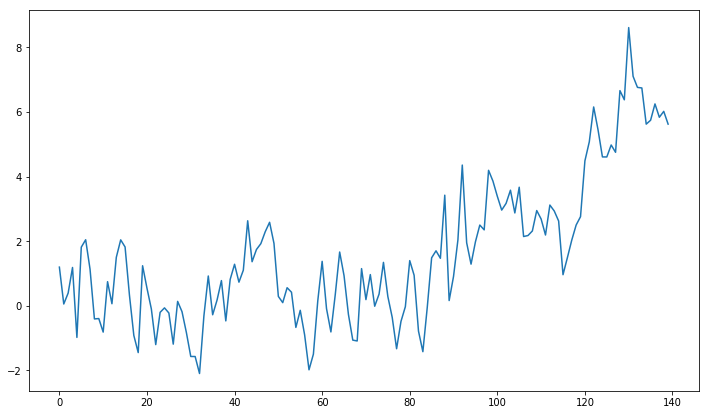

In [37]:
recover3 = np.cumsum(y)
plt.plot(recover3)
plt.savefig('output/simulation.png')